# 1. Import and Install Dependencies

In [ ]:
import cv2
import numpy as np
import os
import time
import mediapipe as mp
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import pyttsx3
import threading
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from googletrans import Translator
from gtts import gTTS
import soundfile as sf
import io
import tempfile
from scipy import stats
import random

In [ ]:
# Initialize MediaPipe Hands solution
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Initialize NLU Model
model_NLU = TFAutoModelForSeq2SeqLM.from_pretrained("./fine_tuned_t5(3)/")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_t5(3)/")

In [ ]:
# Actions and colors
actions = np.array(['hello', 'good', 'morning', 'thank you', 'name', 'you', 'I', 'work', 'engineer', 'from', 'okay', 
                    'fine', 'mumbai', 'how', 'what', 'who', 'fullstop','no'])
colors = [tuple(random.randint(0, 255) for _ in range(3)) for _ in range(len(actions))]  # Random colors

In [ ]:
from tensorflow.keras.optimizers import Adam
# Load pre-trained action recognition model (LSTM-based)
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(30, 126)))  # First LSTM layer returns sequences
model.add(LSTM(64, return_sequences=False))  # Second LSTM layer outputs only the final vector
model.add(Dense(64, activation='relu'))
model.add(Dense(18, activation='softmax'))  # Output layer with 19 classes
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load model weights (use your actual model's path here)
model.load_weights('./firstpov_model/model_epoch_24.h5')

In [ ]:
# Initialize translator
translator = Translator()

In [ ]:
# Function definitions
def mediapipe_hand_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_hand_landmarks(image, results):
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2),
            )

In [ ]:
def extract_keypoints(results):
    lh = np.zeros(21 * 3)
    rh = np.zeros(21 * 3)
    if results.multi_hand_landmarks and results.multi_handedness:
        for hand_index, hand_landmarks in enumerate(results.multi_hand_landmarks):
            hand_label = results.multi_handedness[hand_index].classification[0].label
            hand_array = np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]).flatten()
            if hand_label.lower() == "left":
                lh = hand_array
            elif hand_label.lower() == "right":
                rh = hand_array
    return np.concatenate([lh, rh])

In [ ]:
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame

In [ ]:
def select_language():
    lang = None
    cv2.namedWindow("Language Selection")
    
    def mouse_callback(event, x, y, flags, param):
        nonlocal lang
        if event == cv2.EVENT_LBUTTONDOWN:
            if 100 < y < 200:
                if 50 < x < 250:  # English
                    lang = 'en'
                elif 300 < x < 500:  # Hindi
                    lang = 'hi'
                elif 550 < x < 750:  # Marathi
                    lang = 'mr'

    cv2.setMouseCallback("Language Selection", mouse_callback)
    
    while lang is None:
        img = np.zeros((300, 800, 3), dtype=np.uint8)
        cv2.putText(img, "Select Output Language", (150, 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        
        cv2.rectangle(img, (50, 100), (250, 200), (0,255,0), -1)
        cv2.putText(img, "English", (70, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2)
        
        cv2.rectangle(img, (300, 100), (500, 200), (255,0,0), -1)
        cv2.putText(img, "Hindi", (330, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2)
        
        cv2.rectangle(img, (550, 100), (750, 200), (0,0,255), -1)
        cv2.putText(img, "Marathi", (570, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2)
        
        cv2.imshow("Language Selection", img)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cv2.destroyWindow("Language Selection")
    return lang

In [ ]:
def nlu_and_tts(sign_sequence, selected_lang):
    try:
        if not sign_sequence:
            return None
            
        input_text = ' '.join(sign_sequence)
        print(f"Processing: {input_text}")  # Debug
        
        # NLU Processing
        inputs = tokenizer.encode(input_text, return_tensors="tf")
        outputs = model_NLU.generate(inputs, max_length=50)
        english_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(f"NLU Output: {english_text}")  # Debug
        
        # Translation
        translated = translator.translate(english_text, dest=selected_lang)
        
        # TTS with in-memory processing
        tts = gTTS(translated.text, lang=selected_lang)
        
        # Use in-memory bytes buffer
        fp = io.BytesIO()
        tts.write_to_fp(fp)
        fp.seek(0)
        
        # Play audio directly from memory
        data, samplerate = sf.read(fp)
        sd.play(data, samplerate)
        sd.wait()
        
        return f"Caption: {english_text}"
        
    except Exception as e:
        print(f"Error in NLU/TTS: {str(e)}")
        return None

In [ ]:
def process_nlu_and_tts_thread(sign_sequence, selected_lang):
    def wrapper():
        caption = nlu_and_tts(sign_sequence, selected_lang)
        if caption:
            global current_caption
            current_caption = caption
    threading.Thread(target=wrapper).start()

In [ ]:
# Main execution
selected_lang = select_language()

# Show confirmation
confirmation_img = np.zeros((200, 600, 3), dtype=np.uint8)
cv2.putText(confirmation_img, f"Speech output will be in {selected_lang}", 
           (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
cv2.imshow("Confirmation", confirmation_img)
cv2.waitKey(2000)
cv2.destroyWindow("Confirmation")

# Initialize variables
sequence = []
sentence = []
predictions = []
sign_sequence = []
threshold = 0.7
last_prediction_time = 3
cooldown_period = 3
current_caption = ""
cap = cv2.VideoCapture(1)

def clean_sentence(sentence):
    """Remove fullstop and empty entries from sentence"""
    return [word for word in sentence if word and word != 'fullstop']

# Initialize MediaPipe after language selection
with mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as hands:
    # Show "Initializing..." message
    init_img = np.zeros((200, 600, 3), dtype=np.uint8)
    cv2.putText(init_img, "Initializing Camera...", 
               (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.imshow("Initializing", init_img)
    cv2.waitKey(1000)
    cv2.destroyWindow("Initializing")
    time.sleep(3)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image, results = mediapipe_hand_detection(frame, hands)
        draw_hand_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
            current_time = time.time()
            if current_time - last_prediction_time > cooldown_period:
                if np.unique(predictions[-10:])[0] == np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 
                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                                last_prediction_time = current_time
                        else:
                            sentence.append(actions[np.argmax(res)])
                            last_prediction_time = current_time

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
        
            if 'fullstop' in sentence:
                clean_sentence_list = clean_sentence(sentence)
                # Clean the sentence before processing
                clean_sentence_list = clean_sentence(sentence)
                
                if len(clean_sentence_list) > 0:  # Only process if we have actual words
                    print(f"Processing sentence: {clean_sentence_list}")
                    process_nlu_and_tts_thread(clean_sentence_list, selected_lang)
                    
                    # Clear the sentence list completely
                    sentence = []
                    
                    # Add cooldown to prevent immediate re-detection
                    last_prediction_time = time.time() + 5  # 5 second cooldown
                # process_nlu_and_tts_thread(sign_sequence, selected_lang)
                # sentence = []
            
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        display_sentence = ' '.join(clean_sentence(sentence))  # Display without fullstop
        cv2.putText(image, display_sentence, (3, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Display caption if available
        if current_caption:
            cv2.putText(image, current_caption, (10, image.shape[0]-20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,0), 2)
        
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
cap.release()
cv2.destroyAllWindows()

In [ ]:
pip install sounddevice soundfile

In [ ]:
from gtts import gTTS
import soundfile as sf
import io
import sounddevice as sd

def test_tts():
    tts = gTTS("Hello world", lang='en')
    fp = io.BytesIO()
    tts.write_to_fp(fp)
    fp.seek(0)
    data, samplerate = sf.read(fp)
    sd.play(data, samplerate)
    sd.wait()

test_tts()

In [ ]:
model_NLU = TFAutoModelForSeq2SeqLM.from_pretrained("./fine_tuned_t5(3)/")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_t5(3)/")

In [ ]:
def predict_sentence(model, sentence):
    inputs = tokenizer(sentence, return_tensors='tf', padding=True, truncation=True)
    output = model.generate(inputs['input_ids'])
    predicted_sentence = tokenizer.decode(output[0], skip_special_tokens=True)
    return predicted_sentence

# Example usage
# Example prediction
test_sentence = "who u"
model = TFAutoModelForSeq2SeqLM.from_pretrained("./fine_tuned_t5(3)/")
print("Original:", test_sentence)
print("Predicted:", predict_sentence(model, test_sentence))
print("Prediction completed.")


# test_input = "hello i good"
# inputs = tokenizer(test_input, return_tensors='tf', padding=True, truncation=True)
# output = model_NLU.generate(inputs['input_ids'])
# prediction = tokenizer.decode(output[0], skip_special_tokens=True)
# print(prediction)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import tensorflow as tf

In [3]:
DATA_PATH = os.path.join('first_pov_DATA')

In [4]:
actions = np.array(['hello', 'good', 'morning', 'thank you', 'name', 'you', 'I', 'work', 'engineer', 'from', 'okay', 
                    'fine', 'mumbai', 'how', 'what', 'who', 'fullstop','no'])

In [5]:
sequence_length = 30

In [6]:
model_path = './firstpov_model/model_epoch_24.h5'

In [7]:
# === REBUILD LABEL MAP ===
label_map = {label: num for num, label in enumerate(actions)}

In [8]:
# === LOAD SEQUENCES AND LABELS FROM DISK ===
sequences, labels = [], []
for action in actions:
    for sequence in os.listdir(os.path.join(DATA_PATH, action)):
        window = []
        for frame_num in range(sequence_length):
            path = os.path.join(DATA_PATH, action, sequence, f"{frame_num}.npy")
            res = np.load(path)
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
# === LOAD SEQUENCES AND LABELS FROM DISK ===
sequences, labels = [], []

print(f"\n📥 Loading dataset from: {DATA_PATH}\n")

for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    action_sequences = os.listdir(action_path)
    print(f"▶ Loading action: '{action}' ({len(action_sequences)} sequences)")

    for sequence in action_sequences:
        window = []
        for frame_num in range(sequence_length):
            path = os.path.join(action_path, sequence, f"{frame_num}.npy")
            try:
                res = np.load(path)
                window.append(res)
            except FileNotFoundError:
                print(f"⚠️ Missing: {path}")
                continue
        if len(window) == sequence_length:
            sequences.append(window)
            labels.append(label_map[action])
            print(f"    ✅ Loaded sequence {sequence} for '{action}'")
        else:
            print(f"    ❌ Incomplete sequence {sequence} for '{action}', skipped.")

    print(f"✔️ Completed loading for action: '{action}'\n")

print(f"✅ Finished loading all data: {len(sequences)} samples total.")

In [9]:
X = np.array(sequences)  # Shape: (num_samples, 30, 126)
y = to_categorical(labels).astype(int)  # One-hot encoding

In [10]:
# === SPLIT DATA ===
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_sparse = np.argmax(y_test, axis=1)

In [11]:
# === REBUILD THE MODEL ARCHITECTURE ===
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(30, 126)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# === LOAD TRAINED WEIGHTS ===
model.load_weights(model_path)

In [13]:
# === EVALUATE ===
loss, accuracy = model.evaluate(X_test, y_test_sparse, batch_size=32)
print(f"\n✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}")

12/12 [==============================] - 4s 29ms/step - loss: 0.0236 - accuracy: 0.9917

✅ Test Loss: 0.0236
✅ Test Accuracy: 0.9917


In [14]:
# === PREDICT ===
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

12/12 [==============================] - 2s 27ms/step


In [15]:
# === SAVE ACCURACY SCORE ===
overall_accuracy = accuracy_score(y_test_sparse, y_pred)
print(f"\n📊 Overall Accuracy: {overall_accuracy:.4f}")


📊 Overall Accuracy: 0.9917


In [16]:
# === CLASSIFICATION REPORT ===
print("\n📄 Classification Report:")
print(classification_report(y_test_sparse, y_pred, target_names=actions))


📄 Classification Report:
              precision    recall  f1-score   support

       hello       0.94      1.00      0.97        17
        good       1.00      1.00      1.00        15
     morning       1.00      0.95      0.98        21
   thank you       0.96      1.00      0.98        26
        name       1.00      1.00      1.00        23
         you       1.00      1.00      1.00        25
           I       1.00      1.00      1.00        18
        work       1.00      1.00      1.00        19
    engineer       1.00      1.00      1.00        18
        from       1.00      0.94      0.97        18
        okay       1.00      1.00      1.00        17
        fine       1.00      1.00      1.00        15
      mumbai       1.00      1.00      1.00        22
         how       0.96      1.00      0.98        24
        what       1.00      1.00      1.00        22
         who       1.00      0.95      0.97        19
    fullstop       1.00      1.00      1.00        15
 

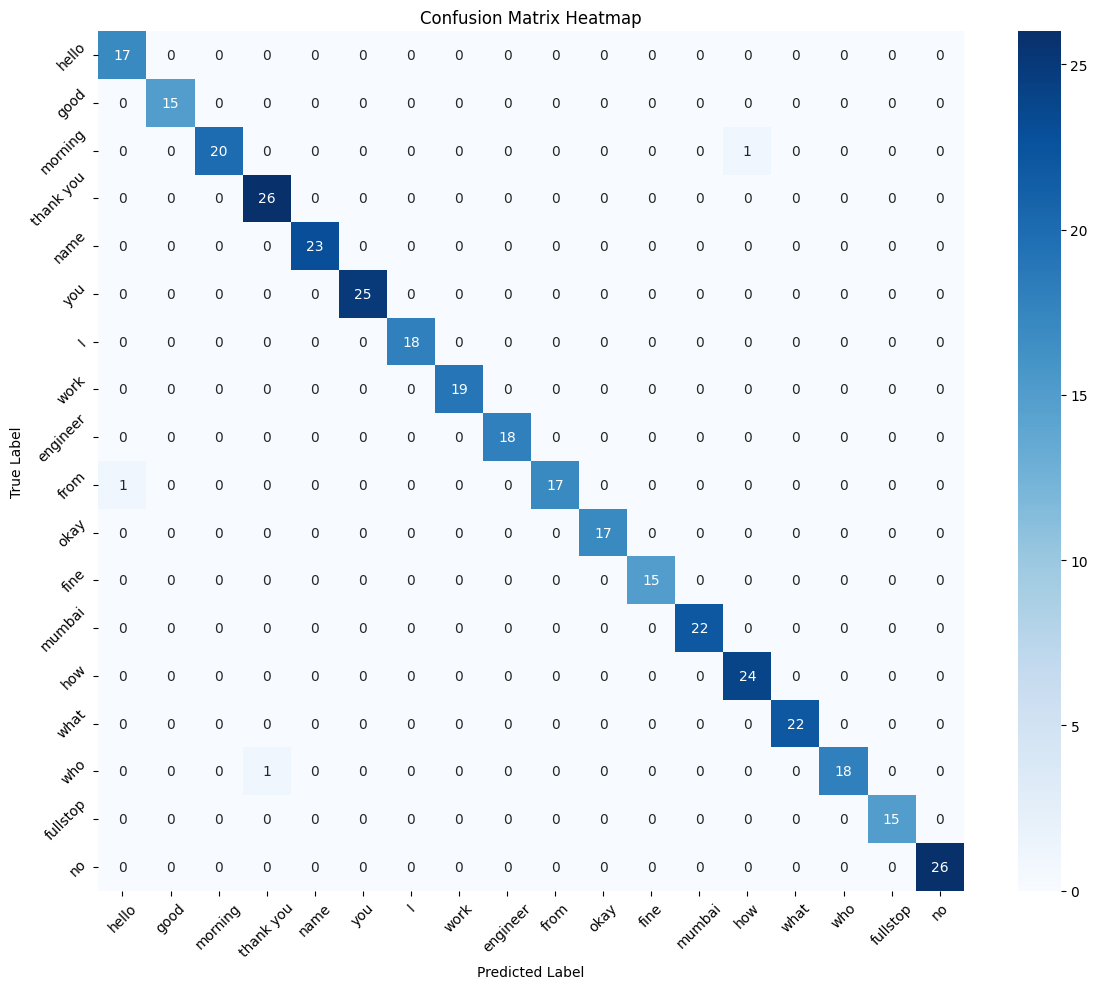

In [17]:
# === CONFUSION MATRIX HEATMAP ===
cm = confusion_matrix(y_test_sparse, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

In [18]:
# === OPTIONAL: t-SNE FEATURE SPACE VISUALIZATION ===
print("⏳ Generating t-SNE projection (this may take a minute)...")
feature_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
features = feature_model.predict(X_test)

⏳ Generating t-SNE projection (this may take a minute)...
12/12 [==============================] - 2s 26ms/step


In [19]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

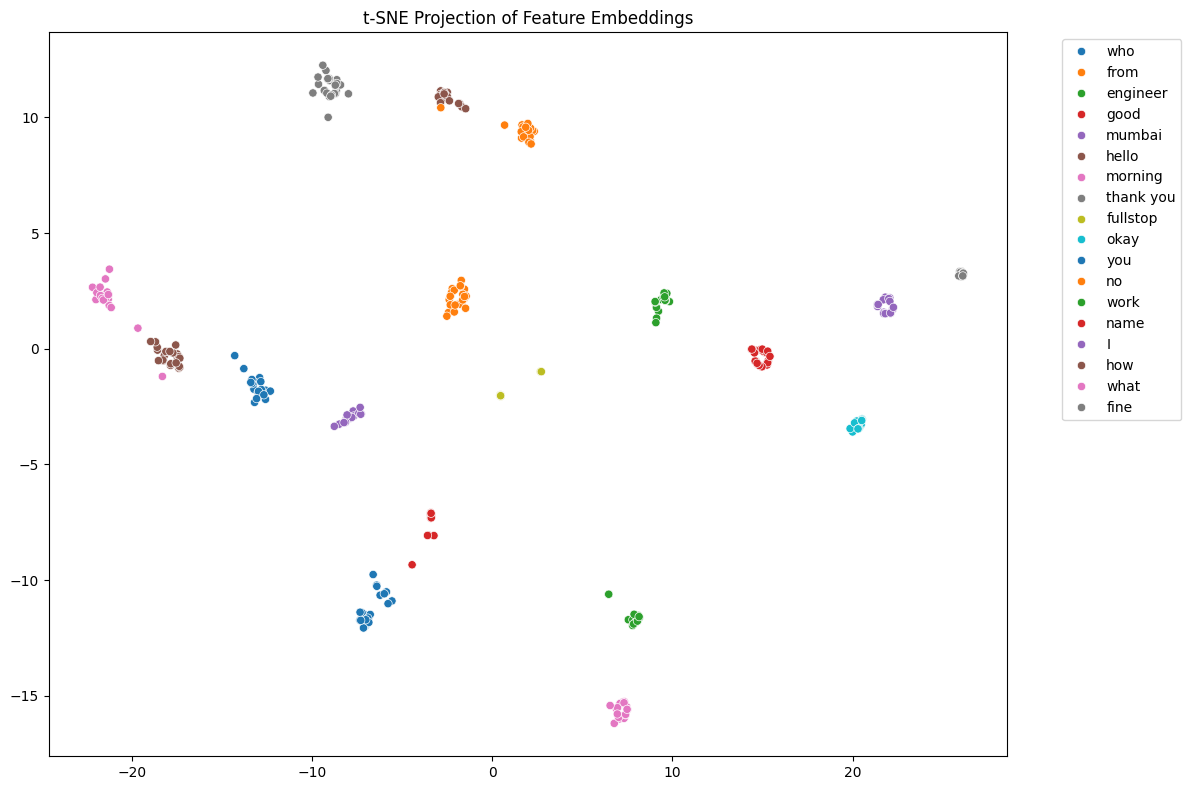

In [20]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=[actions[i] for i in y_test_sparse], palette='tab10')
plt.title("t-SNE Projection of Feature Embeddings")
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig("tsne_projection.png", dpi=300)
plt.show()

In [21]:
print("\n📁 Saved: 'confusion_matrix.png' and 'tsne_projection.png'")


📁 Saved: 'confusion_matrix.png' and 'tsne_projection.png'


In [ ]:
draw_hand_landmarks(frame, results)

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [ ]:
if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        print(len(hand_landmarks.landmark))  # Length will always be 21 for detected hands


In [ ]:
import numpy as np

def extract_keypoints(results):
    # Initialize left and right hand keypoints as zero arrays
    lh = np.zeros(21 * 3)
    rh = np.zeros(21 * 3)

    # Check if hands are detected
    if results.multi_hand_landmarks and results.multi_handedness:
        for hand_index, hand_landmarks in enumerate(results.multi_hand_landmarks):
            # Determine if the hand is left or right
            hand_label = results.multi_handedness[hand_index].classification[0].label
            hand_array = np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]).flatten()

            if hand_label.lower() == "left":
                lh = hand_array
            elif hand_label.lower() == "right":
                rh = hand_array

    # Return concatenated hand keypoints
    return np.concatenate([lh, rh])

In [ ]:
result_test = extract_keypoints(results)

In [ ]:
np.save('0', result_test)


In [ ]:
loaded_result_test = np.load('0.npy')


In [ ]:
print("Extracted Keypoints:", loaded_result_test)

# 4. Setup Folders for Collection

In [ ]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('first_pov_DATA')

# Actions that we try to detect
actions = np.array(['hello', 'good', 'morning', 'thank you', 'name', 'you', 'I', 'work', 'engineer', 'from', 'okay', 
                    'fine', 'mumbai', 'how', 'what', 'who', 'fullstop','no'])

# Thirty videos worth of data (Number of sequences/videos for each action)
no_sequences = 100

# Videos are going to be 30 frames in length (frames per sequence)
sequence_length = 30

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
import os
import numpy as np
import cv2


# Action to process
current_action = "fullstop"

# Directory for the action
action_path = os.path.join(DATA_PATH, current_action)

# Check if action exists in dataset
if current_action in actions and os.path.exists(action_path):
    for sequence in range(1, no_sequences + 1):
        sequence_folder = os.path.join(action_path, str(sequence))
        
        if os.path.exists(sequence_folder):
            print(f"Processing sequence folder: {sequence_folder}")
            
            for frame_num in range(sequence_length):
                npy_path = os.path.join(sequence_folder, f"{frame_num}.npy")
                
                if os.path.exists(npy_path):
                    # Load the .npy file
                    keypoints = np.load(npy_path)
                    
                    # Here you can process the keypoints (e.g., use for training, visualization, etc.)
                    print(f"Frame {frame_num} keypoints shape: {keypoints.shape}")
                    
                else:
                    print(f"Frame {frame_num} does not exist in {sequence_folder}")
        else:
            print(f"Sequence folder {sequence_folder} does not exist!")
else:
    print(f"Action '{current_action}' does not exist in dataset!")

print("Dataset processing completed!")


# 6. Preprocess Data and Create Labels and Features

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
label_map

In [ ]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
np.array(sequences).shape

In [ ]:
np.array(labels).shape

In [ ]:
X = np.array(sequences)

In [ ]:
X.shape

In [ ]:
y = to_categorical(labels).astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
y_test.shape

In [ ]:
print(X_train.shape, y_train.shape)


In [ ]:
y_train_sparse = np.argmax(y_train, axis=1)
print(y_train_sparse.shape)  # Should be (1600,)


In [ ]:
print("y_train_sparse shape:", y_train_sparse.shape)
print("First 5 entries in y_train_sparse:", y_train_sparse[:5])


In [ ]:
print(f"Input shape for prediction: {np.expand_dims(sequence, axis=0).shape}")


# 7. Build and Train LSTM Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
import os

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
# Setup the custom LambdaCallback to save model at every even epoch
checkpoint_dir = os.path.join('checkpoints_fpov(w/o stop)(3)')
os.makedirs(checkpoint_dir, exist_ok=True)

def save_at_even_epochs(epoch, logs):
    if epoch % 2 == 0:  # Check if epoch is even
        model.save(os.path.join(checkpoint_dir, f'model_epoch_{epoch}.h5'))
        print(f"Saved model at epoch {epoch}")
        
    # # Optionally print the training and validation losses and accuracies for each epoch
    # print("/n"
    #     + f"Epoch {epoch}: "
    #       f"Training Loss = {logs['loss']}, Validation Loss = {logs['val_loss']}, "
    #       f"Training Accuracy = {logs['categorical_accuracy']}, Validation Accuracy = {logs['val_categorical_accuracy']}")

# Using LambdaCallback to save model at every even epoch
checkpoint_callback = LambdaCallback(on_epoch_end=save_at_even_epochs)

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(30, 126)))  # First LSTM layer returns sequences
model.add(LSTM(64, return_sequences=False))  # Second LSTM layer outputs only the final vector
model.add(Dense(64, activation='relu'))
model.add(Dense(18, activation='softmax'))  # Output layer with 19 classes


In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
y_test_sparse = np.argmax(y_test, axis=1)  # Converts one-hot encoded labels to integer class labels


In [ ]:
print("y_test_sparse shape:", y_test_sparse.shape)
print("Unique values in y_test_sparse:", np.unique(y_test_sparse))  # Should range from 0 to 18


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_sparse),
    y=y_train_sparse
)
class_weights_dict = dict(enumerate(class_weights))

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with the callbacks
model.fit(
    X_train, y_train_sparse, 
    class_weight=class_weights_dict,
    validation_split=0.2,
    epochs=30, batch_size=32,
    callbacks=[tb_callback, checkpoint_callback, lr_scheduler, early_stopping]
)


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_sparse, batch_size=32)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_sparse),
    y=y_train_sparse
)
class_weights_dict = dict(enumerate(class_weights))

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with the callbacks
model.fit(
    X_train, y_train_sparse, 
    class_weight=class_weights_dict,
    validation_split=0.2,
    epochs=30, batch_size=32,
    callbacks=[tb_callback, checkpoint_callback, lr_scheduler, early_stopping]
)


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_sparse, batch_size=32)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_sparse),
    y=y_train_sparse
)
class_weights_dict = dict(enumerate(class_weights))

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with the callbacks
model.fit(
    X_train, y_train_sparse, 
    class_weight=class_weights_dict,
    validation_split=0.2,
    epochs=30, batch_size=32,
    callbacks=[tb_callback, checkpoint_callback, lr_scheduler, early_stopping]
)


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_sparse, batch_size=32)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


In [ ]:
y_test_sparse = np.argmax(y_test, axis=1)  # Converts one-hot encoded labels to integer class labels


In [ ]:
print("y_test_sparse shape:", y_test_sparse.shape)
print("Unique values in y_test_sparse:", np.unique(y_test_sparse))  # Should range from 0 to 18


In [ ]:
model.save('model_with_class_weights(1)(w/o stop).h5')


In [ ]:
model.summary()

In [ ]:
print("X_train shape:", X_train.shape)


In [ ]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
misclassified_indices = np.where(y_pred != y_test_sparse)[0]
print("Misclassified samples:", misclassified_indices)


# 8. Make Predictions

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[1])]

In [ ]:
actions[np.argmax(y_test[1])]

# 9. Save Weights

In [ ]:
model.save('action.keras')

In [ ]:
model.save('f_pov.h5')

In [ ]:
# del model

In [ ]:
model.load_weights("C:/Users/zaeem/Desktop/sih/sih/ActionDetectionforSignLanguage/checkpoints_fpov(w\o stop)(1)/model_epoch_24.h5")

# 10. Evaluation using Confusion Matrix and Accuracy

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

In [ ]:
from sklearn.metrics import accuracy_score
overall_accuracy = accuracy_score(ytrue, yhat)
print(f"Overall Accuracy: {overall_accuracy}")


# 11. Test in Real Time

In [ ]:
from scipy import stats

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
print("Unique classes in ytrue:", set(ytrue))
print("Unique classes in yhat:", set(yhat))

In [ ]:
actions = sorted(list(set(ytrue)))  # Or set(yhat), depending on your preference

In [ ]:
from sklearn.metrics import classification_report

# Corrected actions list
actions = [str(i) for i in sorted(list(set(ytrue)))]  # Convert to strings

# Generate classification report
report = classification_report(ytrue, yhat, target_names=actions)
print("Classification Report:\n", report)

In [ ]:
from scipy import stats

In [ ]:
import random
actions = np.array(['hello', 'good', 'morning', 'thank you', 'name', 'you', 'I', 'work', 'engineer', 'from', 'okay', 
                    'fine', 'mumbai', 'how', 'what', 'who', 'fullstop','no'])


colors = [tuple(random.randint(0, 255) for _ in range(3)) for _ in range(len(actions))]  # Random colors
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
import time
import cv2
import numpy as np

# New detection variables
sequence = []
sentence = []
predictions = []
sign_sequence = []  # To store the complete sequence of signs
threshold = 0.5

# Cooldown timer
last_prediction_time = 3
cooldown_period = 5  # in seconds

# cap = cv2.VideoCapture(url, cv2.CAP_FFMPEG)
cap = cv2.VideoCapture(2)
res = np.zeros(len(actions)) 

# Set mediapipe model
with mp_hands.Hands(static_image_mode=False, 
                    max_num_hands=2, 
                    min_detection_confidence=0.5, 
                    min_tracking_confidence=0.5) as hands:
    # Wait for 3 seconds before starting detection
    print("Initializing feed... Waiting for 3 seconds...")
    time.sleep(3)

    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results = mediapipe_hand_detection(frame, hands)
        print(results)
        
        # Draw landmarks
        draw_hand_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_sign = actions[np.argmax(res)]
            print(f"Predicted Sign: {predicted_sign}")  # Display the current sign in the cmd
            predictions.append(np.argmax(res))

            # Add sign to sign_sequence if not repeated
            if res[np.argmax(res)] > threshold:
                if len(sign_sequence) == 0 or sign_sequence[-1] != predicted_sign:
                    sign_sequence.append(predicted_sign)

        # Check for full stop
        if "fullstop" in sign_sequence:
            print("Full stop detected. Final sequence:", sign_sequence)
            break  # Exit the loop upon detecting "fullstop"

        # 3. Viz logic
        current_time = time.time()

        if current_time - last_prediction_time > cooldown_period:  # Check cooldown
            if len(predictions) >= 10:  # Ensure there are at least 10 predictions
                if np.unique(predictions[-10:])[0] == np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 

                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                                last_prediction_time = current_time  # Reset cooldown
                        else:
                            sentence.append(actions[np.argmax(res)])
                            last_prediction_time = current_time  # Reset cooldown

        if len(sentence) > 5: 
            sentence = sentence[-5:]

        # Viz probabilities
        image = prob_viz(res, actions, image, colors)
        
        # Show sentence on the screen
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Print the sentence in cmd
        print(f"Signed Text: {' '.join(sentence)}")  # Display the sentence in the cmd
        print("Current Sign Sequence:", sign_sequence)  # Display the sign sequence

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
print(f"Input shape for prediction: {np.expand_dims(sequence, axis=0).shape}")


In [ ]:
pip list


In [ ]:
import tensorflow as tf
from transformers import T5Tokenizer, T5ForConditionalGeneration, TFAutoModelForSeq2SeqLM, AutoTokenizer

# Load your fine-tuned model and tokenizer
model = TFAutoModelForSeq2SeqLM.from_pretrained("C:/Users/zaeem/Desktop/sih/sih/ActionDetectionforSignLanguage/NLU_model")
tokenizer = AutoTokenizer.from_pretrained("C:/Users/zaeem/Desktop/sih/sih/ActionDetectionforSignLanguage/NLU_model")
model = T5ForConditionalGeneration.from_pretrained(nlu_model_path)

# Function to translate unstructured sentences to structured sentences
def predict_sentence(model, sentence):
    inputs = tokenizer(sentence, return_tensors='tf', padding=True, truncation=True)
    output = model.generate(inputs['input_ids'])
    predicted_sentence = tokenizer.decode(output[0], skip_special_tokens=True)
    return predicted_sentence

# Function to process the sign sequence and convert it to text
def process_sign_to_text(sign_sequence):
    # Assuming 'sign_sequence' is a list of actions predicted by the sign language model
    sentence = " ".join(sign_sequence)  # Join the actions into a sentence
    return sentence

# Step 1: Convert the sign sequence into a sentence
test_sentence = process_sign_to_text(sign_sequence)

# Step 2: Use the function to predict the structured sentence from the unstructured input
print("Original (from sign language model):", test_sentence)
predicted_sentence = predict_sentence(model, test_sentence)
print("Predicted Structured Sentence:", predicted_sentence)
print("Prediction completed.")

# NLU Integration 

In [ ]:
!pip install transformers==4.20.0

In [ ]:
import tensorflow as tf
import transformers

print("Tensorflow version:", tf.__version__)
print("Transformers version:", transformers.__version__)

In [ ]:
!pip install pandas==1.3.5


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained("C:/Users/zaeem/Desktop/sih/sih/ActionDetectionforSignLanguage/NLU_model")
tokenizer = AutoTokenizer.from_pretrained("C:/Users/zaeem/Desktop/sih/sih/ActionDetectionforSignLanguage/NLU_model")

In [ ]:
# Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
# Function to translate unstructured sentences to structured sentences
def predict_sentence(model, sentence):
    inputs = tokenizer(sentence, return_tensors='tf', padding=True, truncation=True)
    output = model.generate(inputs['input_ids'])
    predicted_sentence = tokenizer.decode(output[0], skip_special_tokens=True)
    return predicted_sentence

# Example usage
# Example prediction
test_sentence = sign_sequence
sent=predict_sentence(model, test_sentence)
print("Original:", test_sentence)
print("Predicted:", predict_sentence(model, test_sentence))
print("Prediction completed.")

In [ ]:
# Function to translate unstructured sentences to structured sentences
def predict_sentence(model, sentence):
    inputs = tokenizer(sentence, return_tensors='tf', padding=True, truncation=True)
    output = model.generate(inputs['input_ids'])
    predicted_sentence = tokenizer.decode(output[0], skip_special_tokens=True)
    return predicted_sentence

# Example usage
# Example prediction
test_sentence = 'I okay'
sent=predict_sentence(model, test_sentence)
print("Original:", test_sentence)
print("Predicted:", predict_sentence(model, test_sentence))
print("Prediction completed.")

# Text to Speech

In [ ]:
pip install pyttsx3

In [ ]:
import pyttsx3

def text_to_speech(text):
    # Initialize the text-to-speech engine
    engine = pyttsx3.init()
    
    # Optional: Customize speech properties
    engine.setProperty('rate', 150)  # Speed (default: 200 words per minute)
    engine.setProperty('volume', 1.0)  # Volume (0.0 to 1.0)
    
    # Speak the text
    engine.say(text)
    engine.runAndWait()

# if _name_ == "_main_":
    # Example text input
if __name__ == "__main__":
    # Example text input
    text_to_speech(sent)